# BikeSales Modelling

In [193]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')



In [104]:
#Load the data and infer the date format for the date features

df = pd.read_csv('clean_sport2.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  infer_datetime_format=True)
df.head()
sport = df

In [105]:
# sport.drop(['Body','Drive_Type','Fuel_Type','Gear_Change_Method','Gear_Type',
#             'Network_ID','Registration_Plate','URL','Windscreen'], axis=1, inplace=True)

# SELECT INDIVIDUAL FEATURES - we want to simplify the model

In [194]:
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [107]:
def add_dummy_variables(df, categorical_features):
    
    additional = pd.get_dummies(df[categorical_features])
    df[additional.columns] = additional
    return df.drop(categorical_features, axis=1)

def feature_plot(model,X,top=10):
    
    feats_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['FeatureImportance'])
    feats_imp = feats_imp.sort_values('FeatureImportance', ascending=False)[:top]

    feats_imp.plot(kind='barh', figsize=(12,6), legend=False)
    plt.title('Feature Importance from XgBoost Classifier')
    sns.despine(left=True, bottom=True)
    plt.gca().invert_yaxis()
    
def plot_accuracy_predictions(y_test, pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    

In [108]:
print (sport.shape)
sport_numbers = sport.select_dtypes(include='number')
print (sport_numbers.shape)



(2177, 76)
(2177, 32)


In [109]:
sport.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Starter,State,Suburb,Swingarm_Type,Traction_Control,Warranty_KMs,Wheel_Type,Seller,Brand,Model
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Ashgrove,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,South perth,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r special edition
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,QLD,Arana hills,Dual Sided,No,No,Spoke,Private,Kawasaki,Ninja 250r ex250j
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Kawasaki,Ninja 250r ex250j
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,Electric,WA,none,Dual Sided,No,No,Spoke,Dealer,Honda,Cbr250r


In [110]:
numerical_features = list(df.select_dtypes(include='number').columns)
categorical_features = list(df.select_dtypes(exclude='number').columns)

# categorical_features = ['Bike', 'Body', 'Colour', 'Cooling', 'Country_of_Origin', 
#                         'Engine_Config', 'Fuel_Type', 'State', 'Suburb', 'Seller', 
#                         'Brand', 'Model'] 

#categorical_features = ['Bike', 'Body', 'Brand', 'Model', 'Seller']

In [111]:
sport = add_dummy_variables(sport, categorical_features)

In [112]:
sport.head()

,Bore,Carburettor(s),Compression_Ratio,Cylinders,Dry_Weight,Engine_Description,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Reserve_Capacity,Fuel_Tank_Capacity,...,Model_f4 1000 abs,Model_f4 1000s corse,Model_f4 312 r 1000,Model_f4 312 r 1000 11,Model_f4 750 s,Model_f4 750 s f4s 11,Model_f4 r,Model_f4 rr,Model_f4 rr 1000,Model_f4ago 1000
0,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
1,62.0,2.0,11.0,2.0,129.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
2,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
3,62.0,2.0,11.0,2.0,152.0,250.0,290.0,120.0,3.459387,18.0,...,0,0,0,0,0,0,0,0,0,0
4,48.6,4.0,10.0,4.0,129.0,250.0,296.0,118.0,3.459387,13.0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
sport_df = sport.select_dtypes(include='number')

target = 'Price'
features = list(set(sport_df.columns) - set([target]))
#features = ['Age']

sc = StandardScaler()
sc.fit(sport_df[features])
s = sc.transform(sport_df[features])
scaleSport = pd.DataFrame(s,columns=features)

X = scaleSport[features]
y = sport_df[target]


#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [114]:
scaleSport.describe()

,Suburb_Narangba,Ignition_CD (Capacitor Discharge),Wheel_Type_Spoke,Charging_Method_Engine,Bike_MY09,Suburb_Mount sheridan,Suburb_Piara waters,Suburb_Highton,Length,Model_Gsx r1000 30th anniversary edition,...,Suburb_Stirling,Model_f3 675 eas,Suburb_Doonside,Suburb_Narara,Bike_Hayabusa MY15 Road Manual 6sp,Suburb_Glenelg,Carburettor_Constant velocity,Model_959 panigale corse,Suburb_Camden south,Suburb_Gympie
count,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,...,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03,2.177000e+03
mean,-3.370033e-16,6.470511e-16,1.251232e-16,2.215856e-16,4.653457e-16,3.715161e-16,4.812571e-16,4.747294e-16,2.296433e-15,5.152248e-16,...,4.420907e-16,3.247606e-17,-4.239036e-16,1.059130e-16,2.438175e-16,2.136204e-16,-2.492979e-15,3.247606e-17,3.637580e-16,-1.971832e-16
std,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,...,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00
min,-3.032392e-02,-3.032392e-02,-5.840625e+00,-2.468037e+00,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-3.132308e+00,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
25%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-5.550072e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
50%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.587657e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
75%,-3.032392e-02,-3.032392e-02,1.712145e-01,4.051804e-01,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,4.818381e-01,-6.073167e-02,...,-2.143732e-02,-2.143732e-02,-3.032392e-02,-2.143732e-02,-2.143732e-02,-2.143732e-02,-2.621613e-01,-2.143732e-02,-2.143732e-02,-3.714761e-02
max,3.297726e+01,3.297726e+01,1.712145e-01,4.051804e-01,4.664762e+01,4.664762e+01,4.664762e+01,4.664762e+01,3.888616e+00,1.646587e+01,...,4.664762e+01,4.664762e+01,3.297726e+01,4.664762e+01,4.664762e+01,4.664762e+01,3.814446e+00,4.664762e+01,4.664762e+01,2.691963e+01


In [223]:


def adjusted_r2(r2, n, k):
    return 1 - (1-r2)*((n-1)/(n-k-1)) 



def run_model(df, features, y):

    X = df[list(set(df.select_dtypes(include='number').columns) - set('Price'))]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)


    models = []

    models.append(("LassoCV",LassoCV(cv=5)))
    models.append(("LinearRegression",LinearRegression()))
    models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
    models.append(("RidgeCV",RidgeCV(cv=5)))
    models.append(("Bagging",BaggingRegressor()))
    models.append(("SVR",SVR()))

    results = []
    names = []
    n,k = X_train.shape

    for name, model in models:
        score = cross_val_score(model, X_train[features], y_train,  cv=5)
        #score = cross_val_score(model, X[features], y,  cv=5, scoring='r2')
        
        result = adjusted_r2(score,n,k)
        names.append(name)
        results.append(result)

    for i in range(len(names)):
        print(names[i],results[i].mean())
    

    

In [224]:
bike_cols = [col for col in sport_df.columns if 'Bike' in col]
brand_cols = [col for col in sport_df.columns if 'Brand' in col]
model_cols = [col for col in sport_df.columns if 'Model' in col]
niave_feature = ['Kilometers','Age']

In [225]:
run_model(scaleSport, niave_feature, sport_df[target])

LassoCV 224.31112071127637
LinearRegression 224.34643938452714
PassiveAggressiveRegressor 388.42314835066867
RidgeCV 224.32666544718882
Bagging 270.7365405101168
SVR 271.79318925976304


In [219]:
model = RidgeCV(cv=5)

features

['Suburb_Narangba',
 'Ignition_CD (Capacitor Discharge)',
 'Wheel_Type_Spoke',
 'Charging_Method_Engine',
 'Bike_MY09',
 'Suburb_Mount sheridan',
 'Suburb_Piara waters',
 'Suburb_Highton',
 'Length',
 'Model_Gsx r1000 30th anniversary edition',
 'Suburb_Plympton',
 'Suburb_Kelso',
 'Bike_F3 800 RC MY15 Road Manual 6sp',
 'Ground_Clearance',
 'Suburb_New beith',
 'Suburb_Bunya',
 'Suburb_Kilsyth',
 'Suburb_Hope island',
 'Suburb_Indooroopilly',
 'Suburb_Newport',
 'Suburb_Belair',
 'Suburb_Bondi junction',
 'Suburb_Robertson',
 'Suburb_Hurstville',
 'Registration_Expiry_01/02/2018',
 'Rear_Suspension_Spring',
 'Suburb_Amaroo',
 'Suburb_Palmwoods',
 'Suburb_Armstrong creek',
 'Front_Brake_Caliper(s)_Double Piston',
 'Bike_CBR500RA MY17 Road Manual',
 'Suburb_Norwood',
 'Suburb_Nowra',
 'Suburb_Hammondville',
 'Suburb_Brunswick',
 'Suburb_Cabramatta',
 'Bike_S 1000 RR Road Manual 6sp 1000cc',
 'Suburb_Peppermint grove',
 'Suburb_Windsor gardens',
 'Suburb_Greenacres',
 'Suburb_Clontarf',


In [218]:
run_model(sport_df, niave_feature, sport_df[target])

(2177, 1531)
LassoCV -190.2302159160997
LinearRegression -184.58818141803442
PassiveAggressiveRegressor -14207.645349116889
RidgeCV -184.58827858378805
Bagging -214.80104175512633
SVR -136.498193191641


In [173]:
run_model(scaleSport, bike_cols, sport_df[target])

LassoCV 0.7171432066369668 -4.530275692831465
LinearRegression -2.2217769940804805e+28 -2.044114076813369
PassiveAggressiveRegressor -0.6095138114567297 -0.4728052805354348
RidgeCV 0.7205659635489007 0.6730855014099437


In [174]:
run_model(sport_df, bike_cols, sport_df[target])

LassoCV 0.7296428398289155 -9.586112114892607
LinearRegression -7.164664530667441e+25 -2.544833098284323
PassiveAggressiveRegressor -0.5072062908263908 -0.2061881848990723
RidgeCV 0.7396444173524279 0.7128952161373159


In [175]:
run_model(scaleSport, brand_cols, sport_df[target])

LassoCV 0.3387452676578576 -28.1449903412535
LinearRegression -5.47687586522311e+23 -3.650324435098999
PassiveAggressiveRegressor -0.3991878184576044 -2.471219997447626
RidgeCV 0.3386432540149308 0.3205858313723532


In [176]:
run_model(sport_df, brand_cols, sport_df[target])

LassoCV 0.33840490541047374 -29.553489333467716
LinearRegression 0.3357753388465953 -3.681097605895033
PassiveAggressiveRegressor -0.46679333211386115 -2.463182016247263
RidgeCV 0.33812255893146903 0.32081054221356287


In [177]:
run_model(scaleSport, model_cols, sport_df[target])

LassoCV 0.725378471610332 -3.7555148428451544
LinearRegression -1.1988333866221176e+28 -2.8046071571167857
PassiveAggressiveRegressor -0.46379609826071605 -0.3932352553947145
RidgeCV 0.7237746949167747 0.6811343504102307


In [178]:
run_model(sport_df, model_cols, sport_df[target])

LassoCV 0.7360512094600784 -7.166626523979902
LinearRegression -9.57605126443114e+25 -3.102334084578006
PassiveAggressiveRegressor -0.5023946278104081 -0.15361958568169554
RidgeCV 0.7421585653534843 0.7152483763521336


In [188]:
model = RidgeCV(cv=5)

#result = cross_val_score(model, scaleSport[model_cols], sport_df['Price'], cv=5, scoring='r2')
result = cross_val_score(RidgeCV(cv=5), scaleSport[model_cols], sport_df['Price'], cv=5, scoring='r2')


In [189]:
result


array([-3.75551484, -2.80460716, -0.39323526,  0.68113435,  0.65174995])

In [135]:

def run_LinearModel(X_train, X_test, y_train, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    n, k = X_test.shape

    r2 = model.score(X_train,y_train)
    print ('Training: R2:',r2)
    print ('Training: adjusted R2',adjusted_r2(r2, n, k))

    r2 = model.score(X_test,y_test)
    print ('Testing: R2:',r2)
    print ('Testing: adjusted R2',adjusted_r2(r2, n, k))
    print ('mean_squared_error:',mean_squared_error(y_test,pred))
    
    return model, pred



run_LinearModel(X_train, X_test, y_train, y_test)



0.8244687493171682
-9.397128986551567e+27


# Determine which bikes are a good deal

This will be the bikes that have an advertised price lower than the predicted price. The determination of a good deal or not will be based on a threshold of the ratio of the advertised price to the predicted price.

In [136]:
sport_df['Predicted_Price'] = lin.predict(scaleSport[fit_features])

In [138]:
# Tranasform the values back to standard meaning
sport_df[['Price','Predicted_Price']].head()

,Price,Predicted_Price
0,1500.0,2968.0
1,1700.0,3000.0
2,1900.0,2968.0
3,1990.0,2968.0
4,1999.0,3128.0


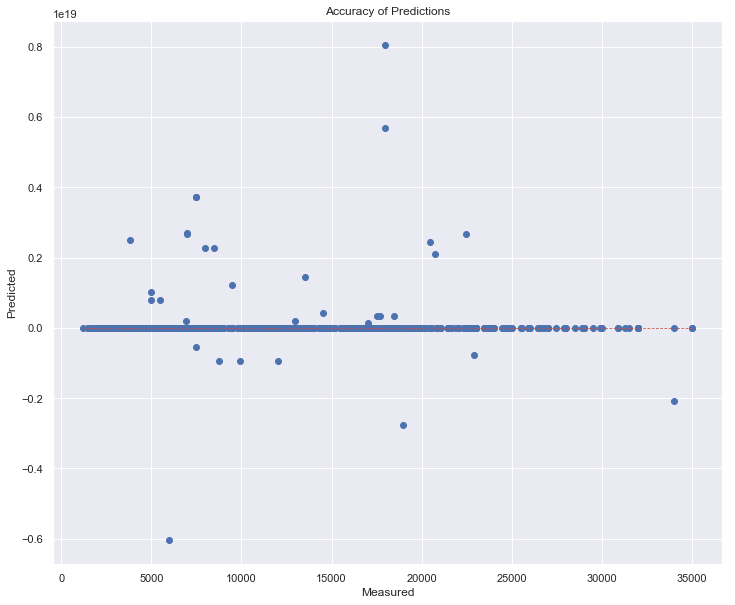

In [141]:
def plot_predictions(y_test,pred):
    fig, ax = plt.subplots(figsize=(12,10))
    ax.scatter(y_test,pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
    ax.set_xlabel('Measured');
    ax.set_ylabel('Predicted');
    ax.set_title('Accuracy of Predictions');
    #ax.set_ylim(0,y_test.max());
    
plot_predictions(sport_df['Price'],sport_df['Predicted_Price'])

In [147]:
sport_df['Price_ratio'] = sport_df['Price'] / sport_df['Predicted_Price']

sport_df['Deal_type'] = 'Dont Bother'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.1] = 'Negotiate'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.2] = 'Good Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 1.5] = 'Great Deal'
sport_df['Deal_type'][sport_df['Price_ratio'] > 2] = 'Its a steel'




,Price,Predicted_Price,Price_ratio,Deal_type
0,1500.0,2968.0,0.505391,Dont Bother
1,1700.0,3000.0,0.566667,Dont Bother
2,1900.0,2968.0,0.640162,Dont Bother
3,1990.0,2968.0,0.670485,Dont Bother
4,1999.0,3128.0,0.639066,Dont Bother
5,2000.0,1944.0,1.028807,Dont Bother
6,2000.0,2968.0,0.673854,Dont Bother
7,2000.0,2472.0,0.809061,Dont Bother
8,2000.0,3000.0,0.666667,Dont Bother
9,2000.0,-616.0,-3.246753,Dont Bother


In [164]:
def scatter(data,x,y,hue=None,title='',figsize=(12,10)):
    ax = plt.figure(figsize=figsize)
    sns.scatterplot(x=x,y=y,hue=hue,data=data);
    plt.title(title,fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim(0,40000)


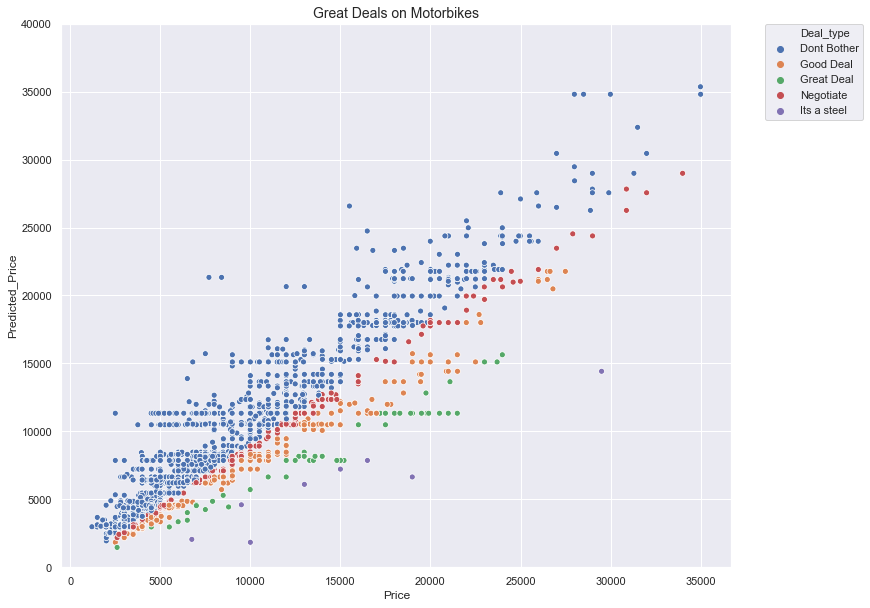

In [165]:
scatter(sport_df,'Price','Predicted_Price',hue='Deal_type',title='Great Deals on Motorbikes')
